In [1]:
import os
import random
import numpy as np
import itertools as it
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, Subset

In [2]:
from torchvision.utils import make_grid

In [3]:
from constants import path_to_data, num_images, num_rotations, patch_size, max_size, label_name_to_value, to_name
from utils import load_png_tuple
from augmentation import random_brightness_and_contrast
from show import *

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [5]:
%load_ext line_profiler

In [6]:
SEED = 238122

In [7]:
def lenghts_split(size, perc):
    train_l =  int(0.9 * size)
    return train_l, size - train_l

In [8]:
random.seed(SEED)
np.random.seed(SEED)

n_img_train, n_img_val = lenghts_split(num_images, .9)

img_indices = np.random.permutation(num_images)
train_ind = img_indices[:n_img_train]
val_ind = img_indices[n_img_train:]

assert len(val_ind) == n_img_val
len(train_ind), len(val_ind)

(376, 42)

In [9]:
from dataset import FacadesDatasetRandomRot, TransformedDataset

In [10]:
dset = FacadesDatasetRandomRot(
    img_dir='{}/images/rot_aug_{}'.format(path_to_data, max_size),
    caching=True,
    #init_caching=True,
)

In [11]:
def random_crop(img, lbl, crop_size=patch_size):
    assert type(img) is torch.Tensor
    
    if type(crop_size) is int:
        crop_x, crop_y = crop_size, crop_size
    else:
        crop_x, crop_y = crop_size
        
    h,w = img.shape[1:]
    top = random.randint(0, h-crop_y)
    left = random.randint(0, w-crop_x)
    img = img[:, top:top+crop_y, left:left+crop_x]
    lbl = lbl[:, top:top+crop_y, left:left+crop_x].long()
    
    img, lbl = random_brightness_and_contrast(img, lbl)
    return img, lbl

In [12]:
dset_train = TransformedDataset(
    dataset=dset,
    transform=lambda img,lbl: random_crop(img, lbl, crop_size=patch_size*2),

)

In [13]:
def closest_multiple(val, m=64):
    n = 0
    while m * n <= val:
        n += 1
    return m * (n-1)

In [14]:
def crop_size(img):
    return tuple(closest_multiple(s) for s in img.shape[1:])[::-1]

In [15]:
dset_val = TransformedDataset(
    dataset=dset,
    transform=lambda img,lbl: random_crop(img, lbl, crop_size=crop_size(img)),
)

(683, 1024, 3) (683, 1024, 1)


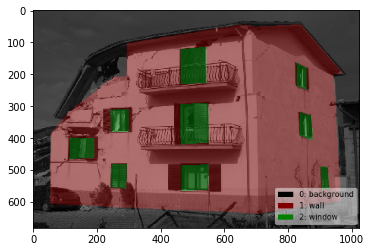

In [16]:
show_labeled_img(*dset[0])

(512, 512, 3) (512, 512, 1)


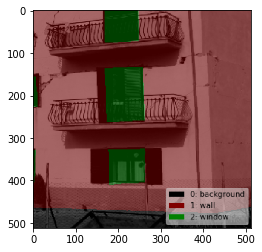

In [17]:
show_labeled_img(*dset_train[0])

(640, 1024, 3) (640, 1024, 1)


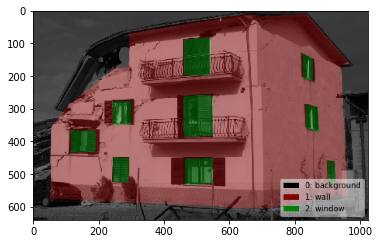

In [18]:
show_labeled_img(*dset_val[0])

## Stats

Weights are not fixed (random crop is applied)

# Model

## DataLoaders

In [19]:
train_dataset = Subset(dset_train, train_ind)
val_dataset = Subset(dset_val, val_ind)

In [20]:
train_batch_size = 8

In [21]:
def to_dataloader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [22]:
dataloaders = {'train': to_dataloader(train_dataset, train_batch_size), 'val': to_dataloader(val_dataset, 1)}

In [23]:
dataset_sizes = {phase: len(dataloaders[phase]) for phase in ['train', 'val']}

In [24]:
dataset_sizes

{'train': 47, 'val': 42}

(1030, 2058, 3) (1030, 2058)


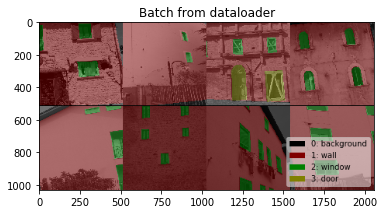

In [25]:
show_batch(*next(iter(dataloaders['train'])), label_name_to_value, 4)

## Training

In [26]:
from models import AlbuNet
from train import train_model
from loss_and_metric import dice_loss, jaccard_index

from tensorboardX import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler

In [27]:
def load_model_weights(model, model_name, epoch):
    model_path = '{}/models/model_{}_{}.torch'.format(path_to_data, model_name, epoch)
    model.load_state_dict(torch.load(model_path))
    if hasattr(model, 'epoch_trained'):
        model.epoch_trained = epoch

In [28]:
albunet = AlbuNet(
    num_classes=len(label_name_to_value),
    num_filters=16,
    pretrained=True,
    is_deconv=False,
).to(device)

In [29]:
model_name = 'albunet_dice_aug_512'
criterion = dice_loss
#criterion = torch.nn.CrossEntropyLoss(weights)
optimizer = optim.Adam(albunet.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [30]:
import datetime
import pytz

timezone = pytz.timezone(pytz.country_timezones['ch'][0])
date_time = datetime.datetime.now(tz=timezone).strftime("%Y-%m-%d_%H-%M-%S")

In [31]:
#load_model_weights(albunet, model_name, 200)

In [32]:
with torch.cuda.device(1):
    albunet = train_model(
        device=device,
        dataloaders=dataloaders,
        dataset_sizes=dataset_sizes,
        path_to_data=path_to_data,
        model_name=model_name,
        model=albunet,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=exp_lr_scheduler,
        writer=SummaryWriter('runs/{}_{}.log'.format(model_name, date_time)),
        num_epoch=200,
    )

Epoch [1/200] train: 7/47 batch
Training complete in 0m 26s
Best val Loss: 9223372036854775808.000000
Best val Jacc: 0.000000


In [35]:
load_model_weights(albunet, model_name, 199)

# Showing Predictions

In [36]:
import pickle

from utils import path_to_tuple
from constants import mean, std

In [37]:
img_dir = '{}/labels'.format(path_to_data)
img_paths = [os.path.join(img_dir, fname) for fname in sorted(os.listdir(img_dir))]
img, lbl = path_to_tuple(img_paths[185], label_name_to_value)

(3024, 4032, 1)


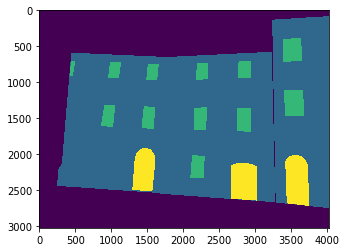

In [38]:
show_img(lbl)

In [39]:
def val_img_predict(idx):
    image, label_true = dset_val[idx]
    output = albunet(image.unsqueeze(0).to(device))
    _, label_pred = torch.max(output, 1)
    return image, label_pred, label_true

In [40]:
pred_stats = dict()
for idx in val_ind:
    _, pred, target = val_img_predict(idx)
    acc_jaccard = jaccard_index(pred, target.squeeze(), n_classes=len(target.unique()))
    pred_stats[idx] = acc_jaccard.mean()

In [57]:
def show(idx):
    img, label_pred, label_true = val_img_predict(idx)
    acc_jaccard = jaccard_index(label_pred, label_true.squeeze(), n_classes=len(label_true.unique()))
    print(idx, acc_jaccard)
    """
    for chan in range(3):
        img[chan] *= torch.tensor(std)[chan]
        img[chan] += torch.tensor(mean)[chan]
    """
    plt.figure(figsize=(16,9))
    show_labeled_img(img, label_pred.cpu())
    plt.figure(figsize=(16,9))
    show_img(label_pred.cpu())
    plt.figure(figsize=(16,9))
    show_img(label_true.cpu())


373 tensor([0.3896, 0.8186, 0.6727])
(1024, 640, 3) (1024, 640, 1)


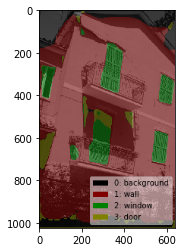

torch.Size([1024, 640, 1])


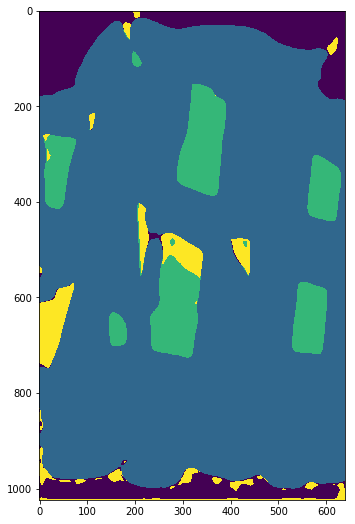

torch.Size([1024, 640, 1])


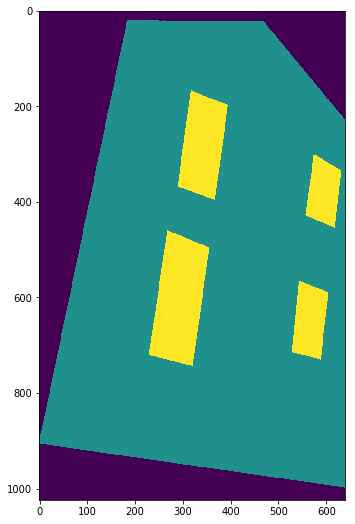

In [58]:
show(max(pred_stats.items(), key=lambda x:x[1])[0])

26 tensor([0.2481, 0.6266, 0.0000])
(640, 1024, 3) (640, 1024, 1)


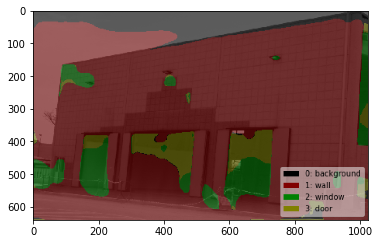

torch.Size([640, 1024, 1])


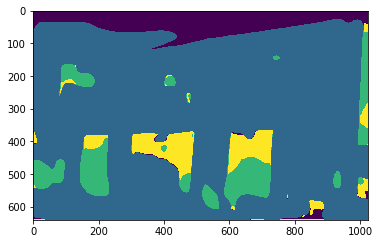

torch.Size([640, 1024, 1])


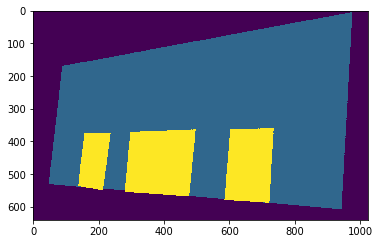

In [43]:
show(min(pred_stats.items(), key=lambda x:x[1])[0])

25 tensor([0.2685, 0.6778, 0.1957])
(640, 1024, 3) (640, 1024, 1)


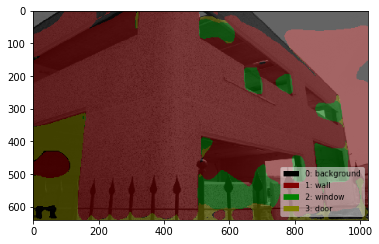

torch.Size([640, 1024, 1])


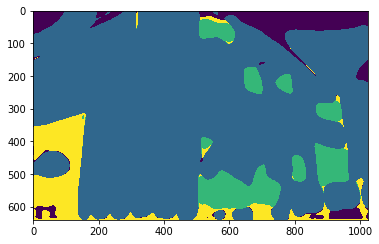

torch.Size([640, 1024, 1])


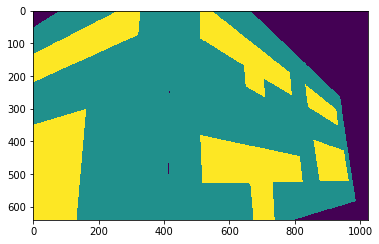

In [44]:
show(25)

317 tensor([0.3920, 0.8384, 0.6024])
(640, 1024, 3) (640, 1024, 1)


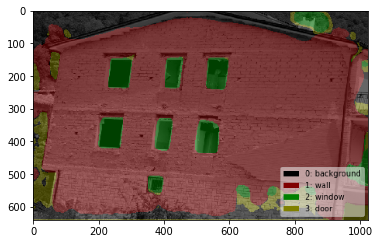

torch.Size([640, 1024, 1])


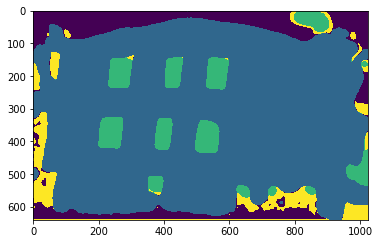

torch.Size([640, 1024, 1])


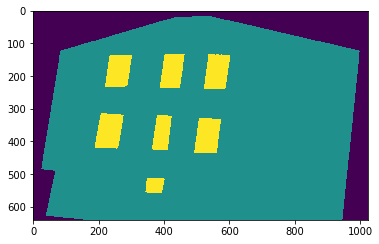

In [45]:
show(317)